In [78]:
import pandas as pd
import os, re
import logging
import fitz 
import joblib
import PyPDF2, docx
import tkinter as tk
import csv
import nltk
import glob
import numpy as np
from joblib import Parallel, delayed
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tkinter import filedialog, messagebox, scrolledtext
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from deep_translator import GoogleTranslator
from PyPDF2 import PdfReader
from docx import Document
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau, ModelCheckpoint

def plot_language_distribution(labels):
    counts = pd.Series(labels).value_counts().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=counts.index, y=counts.values)
    plt.xlabel("Язык")
    plt.ylabel("Количество примеров")
    plt.title("Распределение примеров по языкам")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Фактические значения')
    plt.title('Матрица ошибок')
    plt.tight_layout()
    plt.show()

def plot_learning_curve(history):
    plt.figure(figsize=(12,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],    label='train_acc')
    plt.plot(history.history['val_accuracy'],label='val_acc')
    plt.xlabel('Эпоха'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Кривая точности')
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'],       label='train_loss')
    plt.plot(history.history['val_loss'],   label='val_loss')
    plt.xlabel('Эпоха'); plt.ylabel('Loss');     plt.legend(); plt.title('Кривая потерь')
    plt.tight_layout()
    plt.show()
    
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO)

directory = "C:/Users/pillya/Documents/ish/vkr/datasets/final"
DATA_DIR = r'C:/Users/pillya/Documents/ish/vkr/datasets'
lang_base = ['rus', 'el', 'tr', 'de']
multi_fp = os.path.join(DATA_DIR, 'multi.csv')

lang_dfs = []
for code in lang_base:
    fp = glob.glob(os.path.join(DATA_DIR, f'{code}.*sv'))[0]
    sep = '\t' if fp.endswith('.tsv') else ','
    df = pd.read_csv(fp, sep=sep, header=None,
                     names=['text','value'], encoding='utf-8',
                     engine='python', quoting=csv.QUOTE_NONE,
                     on_bad_lines='skip')
    label = 'de' if code=='deu' else code
    df = df[['text']].assign(label=label)
    lang_dfs.append(df)

dfm     = pd.read_csv(multi_fp, encoding='utf-8')
df_orig = dfm.rename(columns={'content':'text','lang':'label'})[['text','label']]
df_trans = pd.DataFrame({'text': dfm['translated'], 'label':'en'})

df_unified = pd.concat(lang_dfs + [df_orig, df_trans], ignore_index=True)
df_unified = df_unified.sample(frac=1, random_state=42).reset_index(drop=True)

tokenizer = WordPunctTokenizer()

LANG_MAP_NLTK = {
    'ru': 'russian',
    'de': 'german',
    'tr': 'turkish',
    'el': 'greek',
    'en': 'english',
    'pt': 'portuguese',
    'fr': 'french',
    'it': 'italian',
    'es': 'spanish'
}

STOPWORDS_MAP = {
    label: set(stopwords.words(nltk_lang))
    for label, nltk_lang in LANG_MAP_NLTK.items()
}

STEMMER_MAP = {
    label: SnowballStemmer(nltk_lang)
    for label, nltk_lang in LANG_MAP_NLTK.items()
    if nltk_lang in SnowballStemmer.languages
}

def preprocess_text(text, label):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\w\s]', ' ', text).lower()
    tokens = tokenizer.tokenize(text)
    sw = STOPWORDS_MAP.get(label, STOPWORDS_MAP.get('en', set()))
    tokens = [t for t in tokens if t not in sw]
    stemmer = STEMMER_MAP.get(label)
    if stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

NORMALIZE_LABELS = {
    'rus':'ru', 'ru':'ru',
    'deu':'de', 'de':'de',
    'ell':'el','el':'el',
    'tr':'tr','en':'en',
    'pt':'pt','fr':'fr',
    'it':'it','es':'es'
}

df_unified['label'] = df_unified['label'].str.lower().map(NORMALIZE_LABELS)
df_unified = df_unified.dropna(subset=['label'])

RARE = ['it', 'pt', 'fr', 'es']
df_rare = df_unified[df_unified['label'].isin(RARE)]
df_rest = df_unified[~df_unified['label'].isin(RARE)]

df_rare_up = df_rare.sample(frac=3, replace=True, random_state=42)
df_unified = pd.concat([df_rest, df_rare_up], ignore_index=True).sample(frac=1, random_state=42)

texts = df_unified['text'].tolist()
labels = df_unified['label'].tolist()

processed = Parallel(n_jobs=-1)(
    delayed(preprocess_text)(t, l)
    for t, l in zip(texts, labels)
)
    
df_unified['text'] = processed

SUPPORTED_LANGS = sorted(df_unified['label'].unique())
print("Будем работать с языками:", SUPPORTED_LANGS)

Будем работать с языками: ['de', 'el', 'en', 'es', 'fr', 'it', 'pt', 'ru', 'tr']


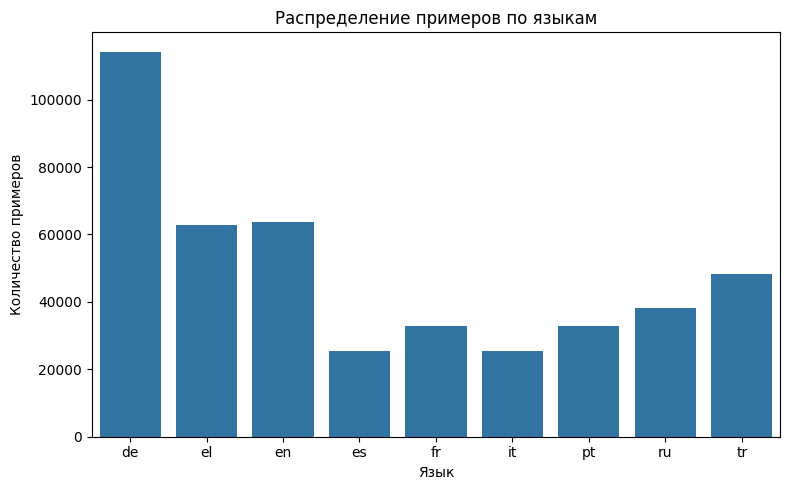

Epoch 1/20


C:\Users\pillya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4976/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.3825
Epoch 1: val_accuracy improved from -inf to 0.88130, saving model to best_model.h5


2025-05-10 01:11:21,453 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8049 - loss: 0.3822 - val_accuracy: 0.8813 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 2/20
4993/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.2720
Epoch 2: val_accuracy improved from 0.88130 to 0.88333, saving model to best_model.h5


2025-05-10 01:11:33,717 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8619 - loss: 0.2720 - val_accuracy: 0.8833 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 3/20
4993/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8684 - loss: 0.2576
Epoch 3: val_accuracy improved from 0.88333 to 0.88676, saving model to best_model.h5


2025-05-10 01:11:45,937 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8684 - loss: 0.2576 - val_accuracy: 0.8868 - val_loss: 0.3217 - learning_rate: 0.0010
Epoch 4/20
4975/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.2523
Epoch 4: val_accuracy improved from 0.88676 to 0.88693, saving model to best_model.h5


2025-05-10 01:11:58,105 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8727 - loss: 0.2522 - val_accuracy: 0.8869 - val_loss: 0.3183 - learning_rate: 0.0010
Epoch 5/20
4986/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8758 - loss: 0.2459
Epoch 5: val_accuracy improved from 0.88693 to 0.88837, saving model to best_model.h5


2025-05-10 01:12:10,565 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8758 - loss: 0.2459 - val_accuracy: 0.8884 - val_loss: 0.3201 - learning_rate: 0.0010
Epoch 6/20
4982/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 - loss: 0.2414
Epoch 6: val_accuracy improved from 0.88837 to 0.88919, saving model to best_model.h5


2025-05-10 01:12:22,767 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8790 - loss: 0.2414 - val_accuracy: 0.8892 - val_loss: 0.3154 - learning_rate: 0.0010
Epoch 7/20
4982/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8803 - loss: 0.2394
Epoch 7: val_accuracy did not improve from 0.88919
4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8803 - loss: 0.2394 - val_accuracy: 0.8890 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 8/20
4989/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.2387
Epoch 8: val_accuracy improved from 0.88919 to 0.89057, saving model to best_model.h5


2025-05-10 01:12:47,539 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8802 - loss: 0.2387 - val_accuracy: 0.8906 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 9/20
4990/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.2322
Epoch 9: val_accuracy improved from 0.89057 to 0.89155, saving model to best_model.h5


2025-05-10 01:12:59,866 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8841 - loss: 0.2322 - val_accuracy: 0.8916 - val_loss: 0.3158 - learning_rate: 5.0000e-04
Epoch 10/20
4992/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8858 - loss: 0.2294
Epoch 10: val_accuracy did not improve from 0.89155
4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8858 - loss: 0.2294 - val_accuracy: 0.8915 - val_loss: 0.3051 - learning_rate: 5.0000e-04
Epoch 11/20
4988/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8864 - loss: 0.2277
Epoch 11: val_accuracy improved from 0.89155 to 0.89178, saving model to best_model.h5


2025-05-10 01:13:24,335 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8864 - loss: 0.2277 - val_accuracy: 0.8918 - val_loss: 0.3118 - learning_rate: 5.0000e-04
Epoch 12/20
4982/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8878 - loss: 0.2254
Epoch 12: val_accuracy improved from 0.89178 to 0.89223, saving model to best_model.h5


2025-05-10 01:13:36,756 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8878 - loss: 0.2254 - val_accuracy: 0.8922 - val_loss: 0.3142 - learning_rate: 5.0000e-04
Epoch 13/20
4992/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.2260
Epoch 13: val_accuracy improved from 0.89223 to 0.89248, saving model to best_model.h5


2025-05-10 01:13:48,981 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8868 - loss: 0.2260 - val_accuracy: 0.8925 - val_loss: 0.3031 - learning_rate: 2.5000e-04
Epoch 14/20
4972/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8887 - loss: 0.2240
Epoch 14: val_accuracy improved from 0.89248 to 0.89302, saving model to best_model.h5


2025-05-10 01:14:01,176 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8887 - loss: 0.2240 - val_accuracy: 0.8930 - val_loss: 0.3081 - learning_rate: 2.5000e-04
Epoch 15/20
4983/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8893 - loss: 0.2220
Epoch 15: val_accuracy did not improve from 0.89302
4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8893 - loss: 0.2220 - val_accuracy: 0.8927 - val_loss: 0.3075 - learning_rate: 2.5000e-04
Epoch 16/20
4993/4994 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2213
Epoch 16: val_accuracy improved from 0.89302 to 0.89319, saving model to best_model.h5


2025-05-10 01:14:25,581 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


4994/4994 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8911 - loss: 0.2213 - val_accuracy: 0.8932 - val_loss: 0.3058 - learning_rate: 1.2500e-04


2025-05-10 01:14:26,162 WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2025-05-10 01:14:26,165 WARNING: You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-05-10 01:14:26,174 INFO: Trained new model and saved best checkpoint
2025-05-10 01:14:28,525 INFO: Test accuracy: 89.30%


2775/2775 ━━━━━━━━━━━━━━━━━━━━ 2s 630us/step


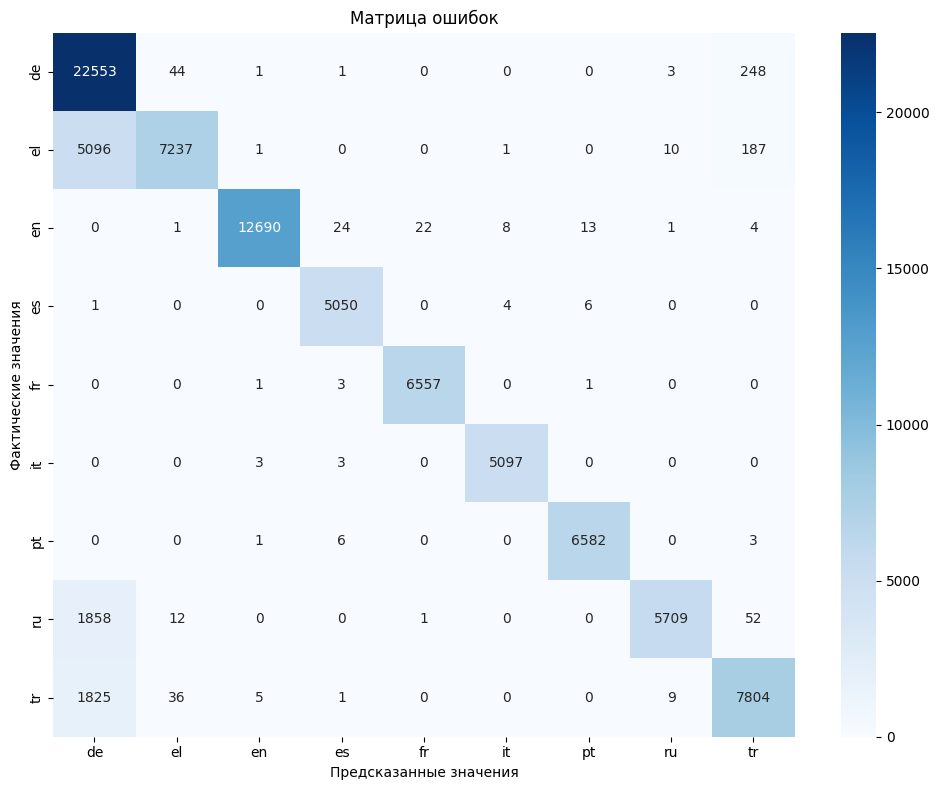

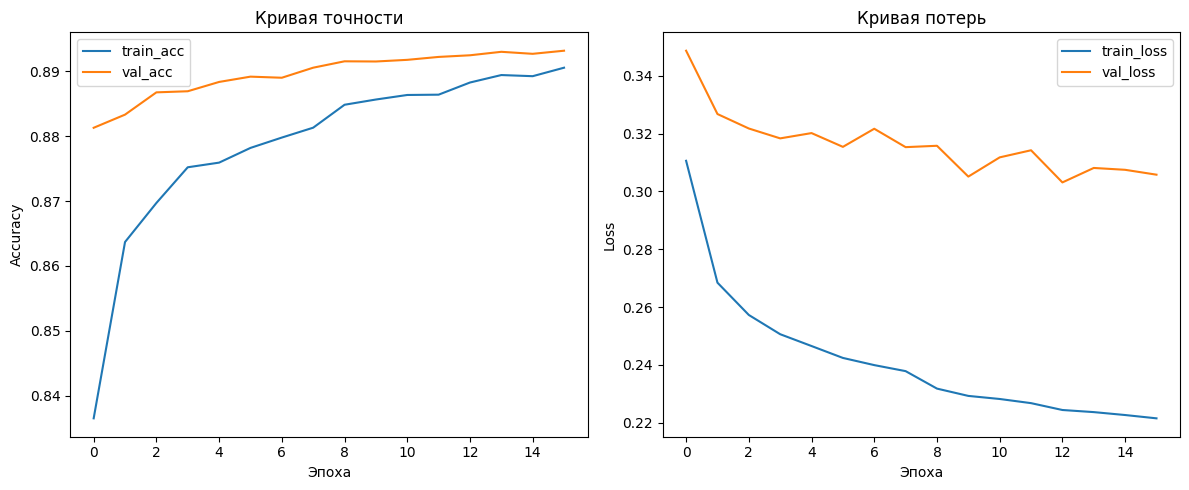

In [79]:
tfidf = TfidfVectorizer(max_features=30000, analyzer='char', ngram_range=(2,4), min_df=5, lowercase=False)
X_sparse = tfidf.fit_transform(df_unified['text'])

joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

X_sparse = X_sparse.astype(np.float32)
svd = TruncatedSVD(n_components=200, random_state=42)
X_reduced = svd.fit_transform(X_sparse)

joblib.dump(svd, 'svd_transformer.joblib')

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df_unified['label'])
joblib.dump(y_encoder, 'label_encoder.joblib')

plot_language_distribution(df_unified['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

classes = np.unique(y_train)

cw_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
cw = dict(zip(classes, cw_values))

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
mcp = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])
    opt = Adam(learning_rate=1e-3)
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

MODEL_FILE = 'keras_lang_model.h5'
BEST_CHECKPT = 'best_model.h5'
input_dim = X_train.shape[1]
num_classes = len(y_encoder.classes_)

loaded = False
if os.path.exists(MODEL_FILE):
    try:
        tmp = load_model(MODEL_FILE)
        if tmp.input_shape[-1] == input_dim:
            model = tmp
            loaded = True
            logging.info(f"Loaded existing model with input_dim={input_dim}")
        else:
            logging.info(f"Model input_dim={tmp.input_shape[-1]} != {input_dim}, will retrain")
    except Exception as e:
        logging.warning(f"Cannot load existing model ({e}), will retrain")

history = None
if not loaded:
    model = build_model(input_dim, num_classes)
    mcp = ModelCheckpoint(
        BEST_CHECKPT,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=64,
        class_weight=cw,      
        callbacks=[es, rlr, mcp]
    )

    model = load_model(BEST_CHECKPT)
    model.save(MODEL_FILE)
    logging.info("Trained new model and saved best checkpoint")

loss, acc = model.evaluate(X_test, y_test, verbose=0)
logging.info(f"Test accuracy: {acc:.2%}")

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(
    y_true=y_encoder.inverse_transform(y_test),
    y_pred=y_encoder.inverse_transform(y_pred),
    classes=list(y_encoder.classes_)
)

if history is not None:
    plot_learning_curve(history)